<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/AMD_Progression/AMD_Research_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
#!pip install util
#import util
import requests, gzip, io
url = "https://data.mendeley.com/datasets/rscbjbr9sj/2/files/5699a1d8-d1b6-45db-bb92-b61051445347/OCT2017.tar.gz?dl=1"

target_path = 'OCT_Images'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())
else:
  print("File not found")
#r = requests.get(data_link)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall()

In [0]:
import tarfile
with tarfile.open('OCT_Images') as tar:
    tar.extractall(path='Data')

In [4]:
TRAIN_DIR = "/content/Data/OCT2017/train"

train_datagen = ImageDataGenerator( rescale = 1.0/255. )

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 83484 images belonging to 4 classes.


In [5]:
TRAIN_DIR = "/content/Data/OCT2017/test"

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

validation_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 1000 images belonging to 4 classes.


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [7]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
8349/8349 [==============================] - 404s 48ms/step - loss: 0.5837 - acc: 0.7918 - val_loss: 0.3010 - val_acc: 0.8890
Epoch 2/2
8349/8349 [==============================] - 335s 40ms/step - loss: 0.4180 - acc: 0.8609 - val_loss: 0.1244 - val_acc: 0.9660


In [0]:
test_img = '/wet_amd.jpg'
#util.compute_gradcam(model, '/content/drive/My Drive/Colab Notebooks/AMD/Wet_AMD/0096032L-104.jpg')

In [0]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

img = load_img(test_img, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


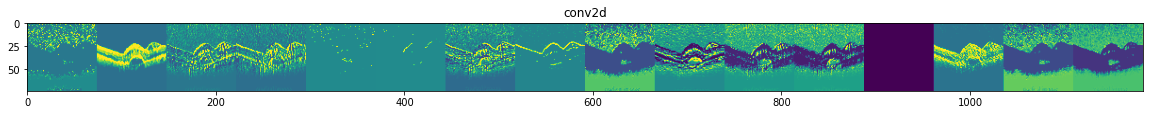

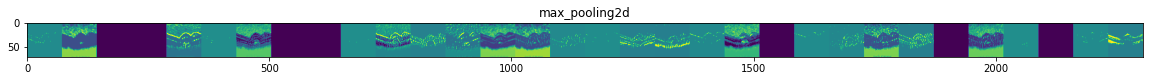

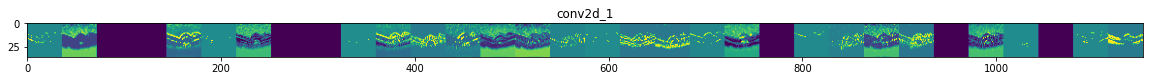

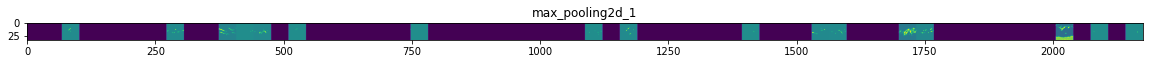

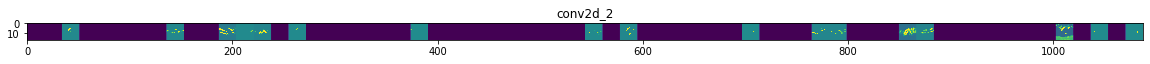

In [14]:
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

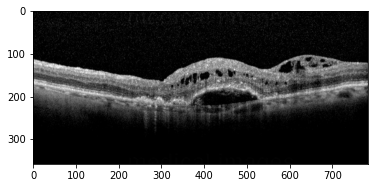

In [15]:
import matplotlib.image as mpimg
img = mpimg.imread(test_img)
plt.imshow(img) 

In [19]:
img = load_img(test_img, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

classes = ['CNV','DME','DRUSEN','NORMAL']
y = model.predict(x)
index = np.argmax(y)
print("Predicted class is",classes[index])
y

Predicted class is CNV


array([[9.9977952e-01, 6.2905499e-05, 1.5750925e-04, 2.1758364e-15]],
      dtype=float32)